# Tri-Mouse Dataset Example

Train dataset: [https://zenodo.org/records/5851157](https://zenodo.org/records/5851157)

Test dataset: [https://zenodo.org/records/8437103](https://zenodo.org/records/8437103)

## Preparation
1. Download and extract the training dataset.

In [1]:
%%bash

# Define variables
TARGET_DIR="dataset/trimice-train/"
ZIP_FILE="trimice-train-dataset.zip"
URL="https://zenodo.org/records/5851157/files/trimice-dlc-2021-06-22.zip?download=1"

# Check if the directory exists
if [ ! -d "$TARGET_DIR" ]; then
    echo "$TARGET_DIR does not exist. Proceeding to download and extract..."

    # Download the file
    curl -o $ZIP_FILE "$URL"
    echo "Downloaded $ZIP_FILE."

    # Create parent directories
    mkdir -p "$TARGET_DIR"

    # Unzip the file
    unzip -q $ZIP_FILE -d $TARGET_DIR
    echo "Extracted files to $TARGET_DIR."

    # Remove the zip file
    rm $ZIP_FILE
    echo "Removed $ZIP_FILE."
else
    echo "$TARGET_DIR already exists. Skipping download and extraction."
fi

echo "Successfully downloaded train dataset."

dataset/trimice-train/ does not exist. Proceeding to download and extract...
Downloaded trimice-train-dataset.zip.
Extracted files to dataset/trimice-train/.
Removed trimice-train-dataset.zip.
Successfully downloaded train dataset.


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23.3M  100 23.3M    0     0  7030k      0  0:00:03  0:00:03 --:--:-- 7030k


2. Similarly, download and extract test dataset.

In [2]:
%%bash

TARGET_DIR="dataset/trimice-test/"
ZIP_FILE="trimice-test-dataset.zip"
URL="https://zenodo.org/records/8437103/files/trimice-dlc-2021-06-22.zip?download=1"

if [ ! -d "$TARGET_DIR" ]; then
    echo "$TARGET_DIR does not exist. Proceeding to download and extract..."

    curl -o $ZIP_FILE "$URL"
    echo "Downloaded $ZIP_FILE."

    mkdir -p "$TARGET_DIR"

    unzip -q $ZIP_FILE -d $TARGET_DIR
    echo "Extracted files to $TARGET_DIR."

    rm $ZIP_FILE
    echo "Removed $ZIP_FILE."
else
    echo "$TARGET_DIR already exists. Skipping download and extraction."
fi

echo "Successfully downloaded test dataset."

dataset/trimice-test/ does not exist. Proceeding to download and extract...
Downloaded trimice-test-dataset.zip.
Extracted files to dataset/trimice-test/.
Removed trimice-test-dataset.zip.
Successfully downloaded test dataset.


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.0M  100 11.0M    0     0  4485k      0  0:00:02  0:00:02 --:--:-- 4486k


3. Download dependecies

In [3]:
%pip install --upgrade ultralytics deeplabcut2yolo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.3/896.3 kB 24.9 MB/s eta 0:00:00


## Convert DeepLabCut (DLC) to YOLO

1. Setup the arguments for d2y.

In [4]:
import deeplabcut2yolo as d2y
from pathlib import Path

dataset_path = Path("dataset/trimice-train/trimice-dlc-2021-06-22")  # Dataset directory to convert using d2y
# Note that the test dataset has no label and does not need to be converted

# List of directories (the folder of images) for training, validation, and testing, accordingly.
val_paths = list(dataset_path.glob("labeled-data/*short/"))
train_paths = [item for item in dataset_path.glob("labeled-data/*/") if item not in val_paths and item.suffix != ".cache"]  # Directories that don't contain the word "short"

# The skeleton from the trimouse dataset is ["snout", "leftear", "rightear", "shoulder", "spine1", "spine2", "spine3", "spine4", "tailbase", "tail1", "tail2", "tailend"].
# The only parts that are symmetric are the leftear (index 1) and the rightear (index 2)
skeleton_symmetric_pairs=[(1, 2)]

2. Run the conversion.

In [5]:
d2y.convert(
    dataset_path=dataset_path,
    train_paths=train_paths,
    val_paths=val_paths,
    skeleton_symmetric_pairs=skeleton_symmetric_pairs,
    data_yml_path="data.yml",
    verbose=True,
)

DeepLabCut2YOLO

Dataset path: dataset/trimice-train/trimice-dlc-2021-06-22
Found pickled labels: dataset/trimice-train/trimice-dlc-2021-06-22/training-datasets/iteration-0/UnaugmentedDataSet_trimiceJun22/trimice_dlc70shuffle1.pickle
Found config file: dataset/trimice-train/trimice-dlc-2021-06-22/config.yaml
  nc: 3
  names: ['mus1', 'mus2', 'mus3']
  kpt: ['snout', 'leftear', 'rightear', 'shoulder', 'spine1', 'spine2', 'spine3', 'spine4', 'tailbase', 'tail1', 'tail2', 'tailend']
  kpt_shape: [12, 3]
Generating data.yml...
Created data.yml: data.yml
  path: /content
  train: ['dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed0', 'dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed2', 'dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed20', 'dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed4', 'dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed1', 'dataset/trimice-train/tri

100%|██████████| 112/112 [00:00<00:00, 2746.87it/s]


Conversion completed!


## YOLO Transfer Learning

In [6]:
from ultralytics import YOLO

model = YOLO("yolov8n-pose.pt").load('yolov8n-pose.pt')
model.train(data="data.yml", epochs=10, imgsz=640)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.52M/6.52M [00:00<00:00, 107MB/s]


Transferred 397/397 items from pretrained weights
Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=pose, mode=train, model=yolov8n-pose.pt, data=data.yml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=yolov8n-pose.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False

100%|██████████| 755k/755k [00:00<00:00, 17.5MB/s]


Overriding model.yaml kpt_shape=[17, 3] with kpt_shape=[12, 3]
Overriding model.yaml nc=1 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True

100%|██████████| 5.35M/5.35M [00:00<00:00, 118MB/s]


AMP: checks passed ✅


train: Scanning /content/dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed0... 62 images, 0 backgrounds, 0 corrupt: 100%|██████████| 62/62 [00:00<00:00, 698.79it/s]

train: New cache created: /content/dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed0.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed06short... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<00:00, 1023.24it/s]

val: New cache created: /content/dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed06short.cache


Plotting labels to runs/pose/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/pose/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       1/10       2.3G      2.974      10.93     0.7291      4.236      2.673         40        640: 100%|██████████| 4/4 [00:05<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all         50        150    0.00409       0.46    0.00593    0.00188   9.84e-05    0.00667    5.3e-05    5.3e-06



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.25G      2.904      10.86      0.721      4.197      2.661         41        640: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         50        150     0.0062      0.653     0.0204    0.00471    0.00011    0.00667   6.03e-05   6.03e-06



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.24G      2.395      10.84     0.7105      3.743      2.232         42        640: 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

                   all         50        150     0.0404      0.113     0.0591     0.0188   0.000223       0.02   0.000115   1.15e-05



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.24G       1.97      10.75     0.6916      3.263      1.783         42        640: 100%|██████████| 4/4 [00:00<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         50        150      0.083     0.0933     0.0418     0.0182   0.000167     0.0133   8.91e-05   8.91e-06



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.25G      1.824       10.5     0.6727      2.826      1.555         40        640: 100%|██████████| 4/4 [00:00<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]

                   all         50        150     0.0953      0.387      0.119     0.0649   0.000179     0.0133   0.000101   1.01e-05



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.26G      1.713      10.31     0.6702      2.762      1.476         41        640: 100%|██████████| 4/4 [00:00<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]


                   all         50        150      0.195      0.533      0.265      0.166    0.00145    0.00667   0.000133   1.97e-05

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.26G      1.568      10.19     0.6718      2.599      1.368         42        640: 100%|██████████| 4/4 [00:00<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

                   all         50        150      0.354      0.254      0.363      0.231    0.00139    0.00667   0.000141   2.47e-05



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.26G      1.503      10.12     0.6736      2.505       1.31         42        640: 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         50        150      0.251      0.427      0.302      0.174   0.000229       0.02   0.000123   1.23e-05



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.26G      1.474       9.99     0.6726      2.433      1.302         41        640: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         50        150      0.269      0.573      0.347      0.201     0.0128    0.00667   0.000506   6.04e-05



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.26G      1.287       9.89     0.6678      2.229      1.162         42        640: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.84it/s]

                   all         50        150       0.29      0.623      0.382      0.225     0.0129    0.00667   0.000742   7.97e-05



10 epochs completed in 0.011 hours.
Optimizer stripped from runs/pose/train/weights/last.pt, 6.6MB
Optimizer stripped from runs/pose/train/weights/best.pt, 6.6MB

Validating runs/pose/train/weights/best.pt...
Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-pose summary (fused): 187 layers, 3,190,589 parameters, 0 gradients, 8.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]


                   all         50        150      0.353      0.254      0.364      0.231    0.00141    0.00667   0.000141   2.47e-05
                  mus1         50         50    0.00229    0.00192      0.152     0.0541    0.00422       0.02   0.000194   3.06e-05
                  mus2         50         50      0.213       0.18      0.152     0.0873          0          0    0.00023   4.34e-05
                  mus3         50         50      0.845       0.58      0.788      0.553          0          0          0          0
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/pose/train


ultralytics.utils.metrics.PoseMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e3f39843580>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(P)', 'F1-Confidence(P)', 'Precision-Confidence(P)', 'Recall-Confidence(P)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.04104

Here are the validation results from the transfer learning.

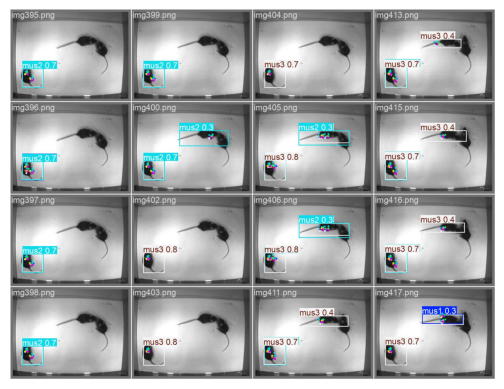

In [7]:
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open(Path("/content/runs/pose/train/val_batch1_pred.jpg"))
plt.imshow(image)
plt.axis('off')
plt.show()

## Test the Model

In [8]:
image_paths=list(Path("/content/dataset/trimice-test/trimice-dlc-2021-06-22/labeled-data/videocompressed0").glob("*"))
results = model(image_paths)


0: 480x640 1 mus1, 1 mus2, 2 mus3s, 6.1ms
1: 480x640 1 mus1, 1 mus2, 2 mus3s, 6.1ms
2: 480x640 1 mus1, 3 mus2s, 2 mus3s, 6.1ms
3: 480x640 1 mus1, 1 mus2, 1 mus3, 6.1ms
4: 480x640 2 mus2s, 2 mus3s, 6.1ms
5: 480x640 1 mus1, 1 mus2, 2 mus3s, 6.1ms
6: 480x640 3 mus1s, 2 mus2s, 3 mus3s, 6.1ms
Speed: 1.2ms preprocess, 6.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


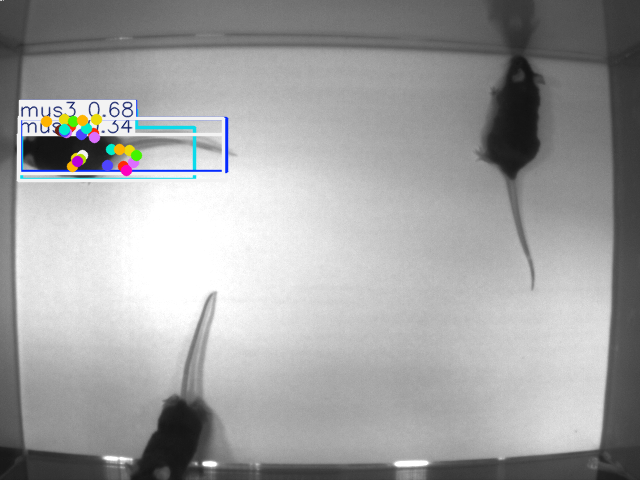

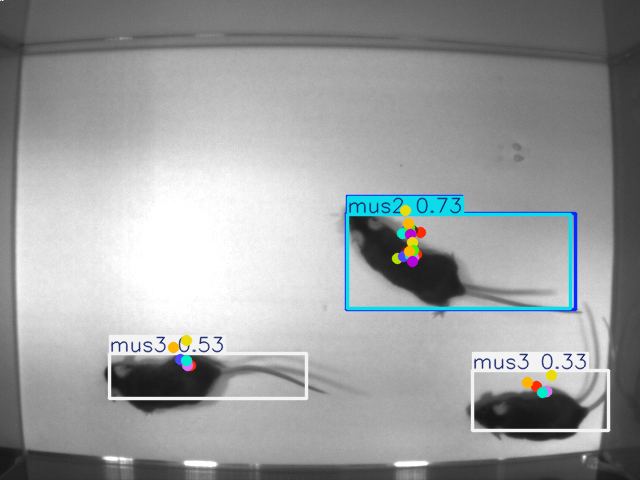

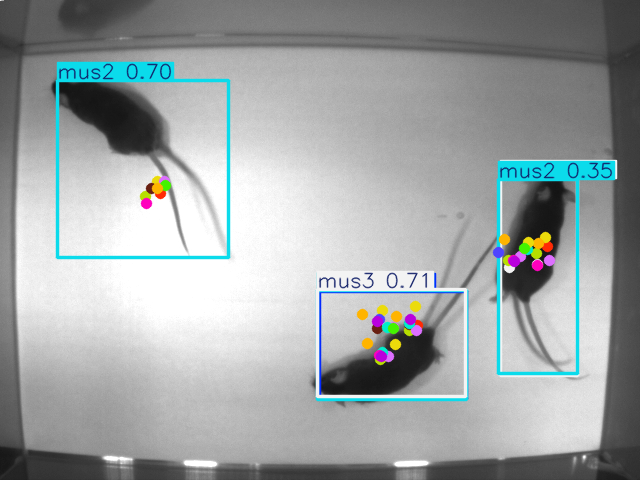

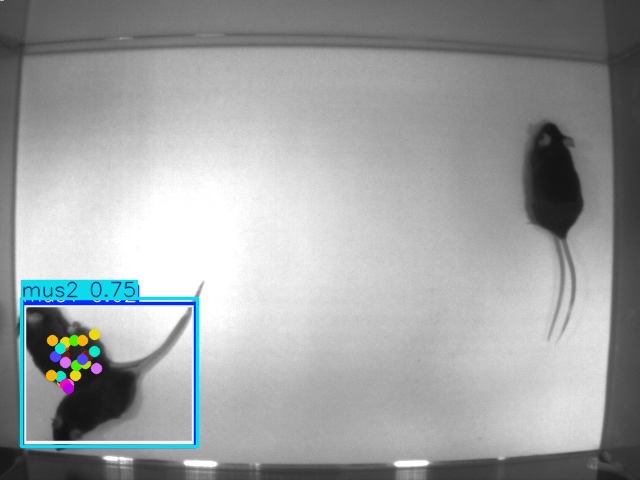

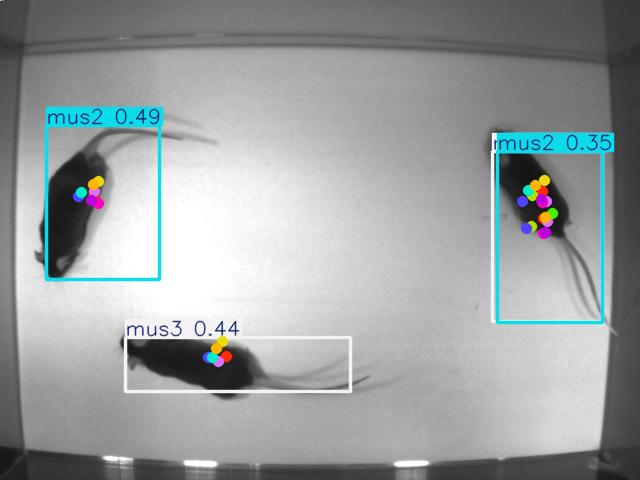

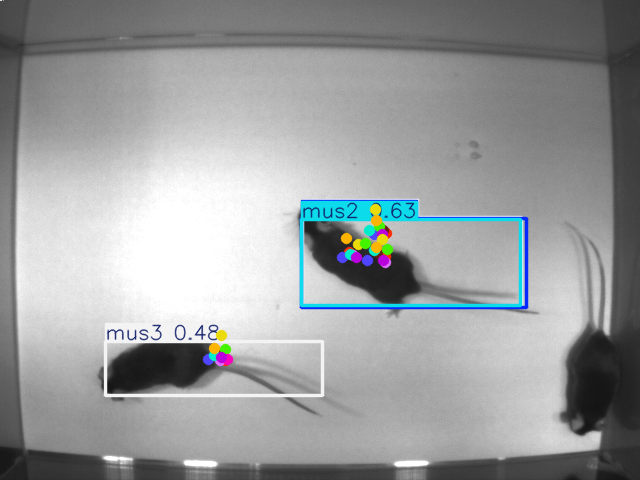

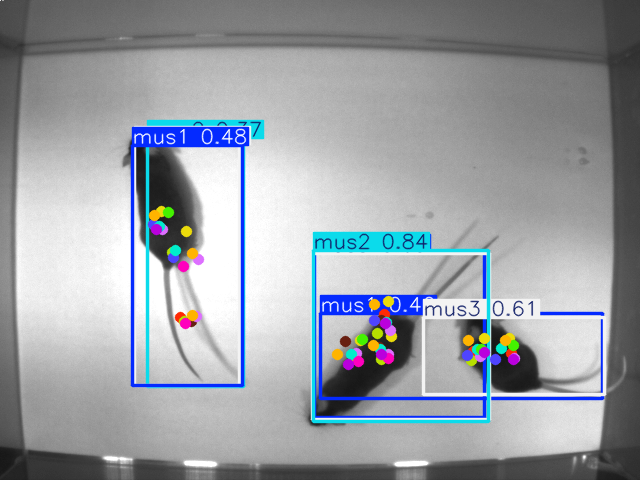

In [9]:
for r in results:
  r.show()